Попробуем решить головоломку c предыдущего семинара c помощью нейронной сети. 

Импортируем нужные функции и модули:

In [18]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from collections import Counter
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

Как и обычно, нам понадобится функция для визуализации процесса обучения — очень важно понимать, что происходит, пока  мы учим нейронную сеть. Будем отслеживать значение функции ошибки и долю правильных ответов для обучающей выборки и валидации.

In [20]:
def plot_progress(train_losses, train_accs, val_loss, val_accs):
    clear_output(True)
    
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
    f.set_figheight(6)
    f.set_figwidth(12)
    
    ax1.plot(train_losses, label='train loss')
    ax1.plot(val_loss, label='test loss')
    ax1.plot(np.zeros_like(train_losses), '--', label='zero')
    ax1.set_title('Loss', fontsize=14)
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Batch number')
    ax1.legend()
    
    ax2.plot(train_accs, label='train accuracy')
    ax2.plot(val_accs, label='val accuracy')
    ax2.plot(np.ones_like(accs), '--', label='100% accuracy')
    ax2.set_title('Accuracy', fontsize=14)
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Batch number')
    ax2.legend()

    plt.show()

Прочитаем файл с данными и убедимся, что он считался верно:

In [21]:
data = pd.read_csv('https://stepik.org/media/attachments/lesson/537384/sequence_puzzle.csv')
data.head()

,sequence,class
0,sjqaeauaknxxorozdxlmarrxrxdwgzaybz:lrphgjfltco...,1
1,nslqardijhgvtqetxkkbl:bvrfgyvmvbphltfjvvilxjat...,0
2,iyqzsuiflsqrcxvgdidnfvxkvzgiys:wnikygtgiyfhpyf...,0
3,rjooxlikqmpydfnibhawleeolfrcikpildaxxhumlawch:...,1
4,pqqsyndxhmdzekcqujpretnjfzzsbpjbjt:nywmpnrfret...,0


Посмотрим на баланс классов, длину строк в среднем и любые другие идеи, которые придут вам в голову:

In [2]:
# <your beautiful code here>

Нам нужно закодировать последовательность перед тем, как подавать её в нейронную сеть — для этого реализуем нужные функции. Чтобы закодировать один элемент последовательности, нужно составить словари символов:

In [36]:
letters = set(''.join(data.sequence))
n_letters = len(letters)

In [37]:
# <your beautiful code here>
letter_index_map =

In [38]:
letter_index_map

{'t': 0,
 'n': 1,
 'j': 2,
 'r': 3,
 'u': 4,
 'k': 5,
 'x': 6,
 'b': 7,
 ':': 8,
 'f': 9,
 'o': 10,
 'z': 11,
 'h': 12,
 'y': 13,
 'q': 14,
 'd': 15,
 'm': 16,
 'a': 17,
 'w': 18,
 'c': 19,
 'g': 20,
 'i': 21,
 's': 22,
 'l': 23,
 'p': 24,
 'v': 25,
 'e': 26}

Реализуем PyTorch Dataset — класс, переводящий одну строчку символов в последовательность индексов.

In [39]:
class SequenceDataset(Dataset):
    
    def __init__(self, lines, labels):
        self.lines = lines
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        x = self.line_to_tensor(self.lines[idx]).long()
        y = torch.tensor(self.labels[idx]).float()
        return x, y
    
    @staticmethod
    def line_to_tensor(line):
        return torch.tensor([letter_index_map[l] for l in line])

Разбиваем данные на обучающую и валидационную выборку, создаём соответствующие объекты DataLoader.

In [40]:
X_train, X_val, y_train, y_val = train_test_split(
    data.sequence,
    data['class'],
    test_size=0.05,
)

train_dataset = SequenceDataset(lines=X_train.values, labels=y_train.values)
val_dataset = SequenceDataset(lines=X_val.values, labels=y_val.values)

In [67]:
train_sequence_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_sequence_dataloader = DataLoader(val_dataset, batch_size=512, shuffle=True)

Разберём подробно архитектуру модели:

#### embedding -> CNN -> FC -> sigmoid

Сказать, что обучаемые эмбеддинги

In [3]:
x = torch.from_numpy(
    np.random.randint(0, len(letter_index_map), (4, 64))
)
print('Our input sample\n', x, ' \nof size:', x.shape)

NameError: name 'torch' is not defined

In [59]:
emb_layer = nn.Embedding(num_embeddings=len(letter_index_map), embedding_dim=8)
emb_output = emb_layer(x)
emb_output.shape

torch.Size([4, 64, 8])

In [60]:
emb_output

tensor([[[ 0.1814, -0.1151,  1.5526,  ..., -1.4403, -0.3702,  1.5418],
         [ 0.4516, -1.2180,  0.3189,  ...,  0.6535,  0.4808,  0.7501],
         [-0.1110, -0.5127, -0.7368,  ..., -0.9410, -0.0417, -0.4409],
         ...,
         [-0.9926, -0.5138, -0.0447,  ..., -0.2430, -0.0377, -0.1758],
         [-0.9192, -0.0176, -1.6054,  ...,  0.8962,  1.3936, -1.5005],
         [ 0.1027,  1.2198, -1.0783,  ...,  0.4908,  1.3987, -0.9556]],

        [[-0.1110, -0.5127, -0.7368,  ..., -0.9410, -0.0417, -0.4409],
         [ 0.1814, -0.1151,  1.5526,  ..., -1.4403, -0.3702,  1.5418],
         [ 0.1814, -0.1151,  1.5526,  ..., -1.4403, -0.3702,  1.5418],
         ...,
         [-1.4457,  0.0091,  0.3145,  ..., -0.4704,  1.0084, -1.4450],
         [-0.9192, -0.0176, -1.6054,  ...,  0.8962,  1.3936, -1.5005],
         [-0.2924, -1.0584, -0.3184,  ..., -2.6849, -0.6493,  0.8326]],

        [[ 0.0704,  0.1120, -0.5697,  ..., -0.0956, -0.7784, -0.4595],
         [-0.2033, -1.2365, -0.3529,  ..., -0

Посмотрим, как свёрточный слой преобразует данные. Для этого в выходе из эмбеддинг-слоя нужно поменять местами оси. Это можно сделать с помощью метода .permute():

In [61]:
print(emb_output.shape)
print(emb_output.permute(0, 2, 1).shape)

torch.Size([4, 64, 8])
torch.Size([4, 8, 64])


Паддинг 'same' сохраняет исходную длину последовательности, при этом размерность векторов получается равной out_channels=16.

In [62]:
conv1d = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=12, padding='same')

conv_output = conv1d(emb_output.permute(0, 2, 1))
conv_output.shape

torch.Size([4, 16, 64])

Далее мы агрегируем всю информацию из последовательности с помощью вычисления максимума:

In [ ]:
max_output, l = conv_output.max(dim=-1)
conv_output.shape, max_output.shape

In [63]:
conv_output[0, 0].argmax(), conv_output[0, 0].max(), l, max_output

(torch.Size([4, 16]),
 torch.Size([4, 16, 64]),
 tensor([[50, 50, 20, 58, 27, 42, 39, 29, 57, 51, 13, 26, 56, 15, 32, 36],
         [20, 22,  5, 38,  2, 45, 44, 14, 17, 50, 51, 10, 18, 49, 50, 52],
         [26, 18, 43, 24, 50, 33, 28,  8,  1, 13, 22, 59, 31, 49, 22, 34],
         [11, 60, 16, 18, 16, 48, 41, 36, 13, 23, 26, 32, 44, 49, 39, 18]]),
 tensor([[1.0662, 1.4171, 1.4870, 1.2720, 1.6506, 0.9183, 1.2542, 1.1315, 0.9397,
          1.1289, 1.3559, 1.2116, 1.2054, 1.6039, 1.1292, 0.9991],
         [1.2017, 1.3242, 1.5970, 1.1326, 1.2329, 1.1783, 1.2505, 1.4555, 1.1456,
          1.2270, 1.6260, 1.4064, 1.4201, 0.9606, 1.6327, 1.4067],
         [0.6511, 1.3640, 1.1930, 0.9829, 2.4494, 1.4087, 1.4334, 1.7147, 1.4971,
          1.1679, 1.6981, 1.0585, 1.0227, 1.1425, 1.0100, 0.9566],
         [0.8805, 1.4837, 1.9691, 1.5178, 1.4482, 1.1781, 1.2003, 1.3611, 1.3563,
          1.2089, 1.7701, 1.4126, 0.8584, 1.2993, 1.3057, 1.5185]],
        grad_fn=<MaxBackward0>))

А теперь соберем все это воедино:

In [71]:
class PuzzleCNN(nn.Module):

    def __init__(self, vocab_size, hidden_size, kernel_size=5, embedding_dim=8):
        super(PuzzleCNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.cnn = nn.Conv1d(embedding_dim, hidden_size, kernel_size=kernel_size, groups=2)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.cnn(x)
        x, _ = x.max(dim=-1)
        x = self.relu(x)
        x = self.linear(x)
        x = self.sigmoid(x).squeeze()
        return x

In [65]:
one_objext_batch_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
x, y = next(iter(one_objext_batch_dataloader))
print(x.shape)
print(x, y)

torch.Size([2, 64])
tensor([[25, 24, 24,  1,  9,  5, 14, 17, 22, 17, 20, 24, 17, 13,  6, 11, 15, 11,
         11,  5,  1, 12,  2, 16,  5, 23,  9, 25,  5,  3, 15,  8, 18, 15,  9,  2,
         11,  9, 17, 15, 16,  6, 17, 24, 18,  2, 19, 10,  4, 21, 14, 25, 11, 14,
         26,  0,  7, 22, 15, 24, 18, 22, 21, 22],
        [11, 21,  1,  2, 25, 23,  3,  9, 24, 16, 12, 11,  1,  3,  3, 20, 23,  4,
         21,  9,  2, 10,  6, 19, 19, 20, 25,  5, 26,  9,  1, 19, 21,  0, 15,  9,
          8, 16,  1, 18,  4, 15, 25,  6, 11, 13,  3, 18, 15, 25, 25, 16, 22, 26,
         15, 12, 10, 22, 23, 23, 23, 16,  5, 16]]) tensor([1., 0.])


Разберём цикл обучения:

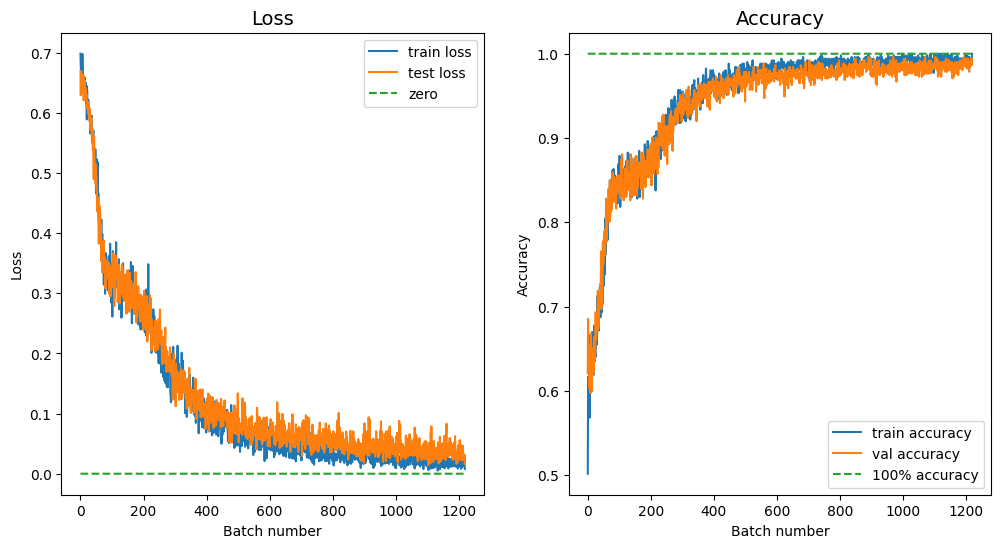

In [76]:
# Инициализируем класс модели, размер внутреннего слоя 16, ширина окна 12
model = PuzzleCNN(
    vocab_size=len(letter_index_map),
    hidden_size=16,
    kernel_size=12,
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Лосс функция – бинарная кросс энтропия (другое название logloss функции ошибки)
loss_func = nn.BCELoss()

n_epochs = 10

# Списки для сохранения истории функции ошибки и доли правильных ответов
losses = []
accs = []

val_losses = []
val_accs = []


for i in range(n_epochs):
    for x_train, y_train in train_sequence_dataloader:

        model.train()
        preds = model(x_train)
        train_loss = loss_func(preds, y_train)
        train_acc = ((preds > 0.5).long() == y_train).float().mean()
        #  считаем долю правильных ответов с порогом
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        model.eval()
        # не рассчитавать градиент по валидационной выборкке про grad и requires_grad

        x_val, y_val = next(iter(val_sequence_dataloader))
        #  генерируем один батч для валидации 0.5
        
        val_preds = model(x_val)
        val_loss = loss_func(val_preds, y_val)
        val_acc = ((val_preds > 0.5).long() == y_val).float().mean()
        
        losses.append(train_loss.item())
        accs.append(train_acc.item())
        
        val_losses.append(val_loss.item())
        val_accs.append(val_acc.item())
        
        plot_progress(losses, accs, val_losses, val_accs)

Теперь посмотрим, как с решением головоломки справится другая архитектура, с которой мы познакомились на лекции — LSTM.

In [75]:
accs[-1], val_accs[-1]

(0.7491856813430786, 0.794921875)

In [77]:
accs[-1], val_accs[-1]

(1.0, 0.994140625)

Какой LSTM брать?

In [21]:
class PuzzleLSTM(nn.Module):
    
    def __init__(self, vocab_size, hidden_size, embedding_dim=8, bidirectional=False):
        super(PuzzleLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.multiplier = 2 if bidirectional else 1
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            input_size=embedding_dim, 
            hidden_size=hidden_size, 
            batch_first=True, 
            bidirectional=bidirectional,
            bias=True,
            num_layers=1
        )
        self.linear = nn.Linear(self.multiplier * hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        print(x.shape)
        x = self.cnn(x)
        x, _ = x.max(dim=-1)
        x = self.relu(x)
        x = self.linear(x)
        x = self.sigmoid(x).squeeze()
        return x

Архитектура сети во многом похожа PuzzleCNN: эмбеддинг-слой и линейный слой для бинарной классификации, но между ними вместо Conv1d уже стоит LSTM.  

Посмотрим, как преобразует входные данные этот слой:

In [80]:
lstm = nn.LSTM(input_size=8, hidden_size=16, num_layers=3)
outputs, (hiddens, cs) = lstm(emb_output)
outputs.shape

torch.Size([4, 64, 16])

Мы можем обучить LSTM для задачи классификации, применяя линейный слой к outputs для последнего токена:

In [23]:
linear_layer = nn.Linear(16, 1)
linear_layer(outputs[:, -1, :].squeeze())

tensor([0.1474], grad_fn=<AddBackward0>)

Выход из линейного слоя преобразуем сигмоидой.

В nn.LSTM можно сразу получить выходы на нужное количество классов — для этого есть параметр proj_size, но мы использовали линейный слой для наглядности происходящего.

Обучим рекуррентную сеть решать задачу:

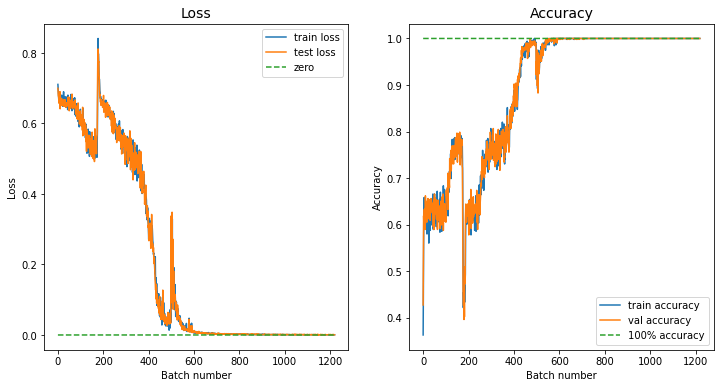

In [28]:
# Инициализируем класс модели, размер внутреннего слоя 16
model = PuzzleLSTM(
    vocab_size=len(letter_index_map),
    hidden_size=16,
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.BCELoss()

n_epochs = 10


losses = []
accs = []

val_losses = []
val_accs = []


for i in range(n_epochs):
    for x_train, y_train in train_sequence_dataloader:

        model.train()
        preds = model(x_train)
        train_loss = loss_func(preds, y_train)
        train_acc = ((preds > 0.5).long() == y_train).float().mean()

        # zero_grad, backward, step
        # <your beautiful code here>

        x_val, y_val = next(iter(val_sequence_dataloader))
        
        val_preds = model(x_val)
        val_loss = loss_func(val_preds, y_val)
        val_acc = ((val_preds > 0.5).long() == y_val).float().mean()
        
        losses.append(train_loss.item())
        accs.append(train_acc.item())
        
        val_losses.append(val_loss.item())
        val_accs.append(val_acc.item())
        
        plot_progress(losses, accs, val_losses, val_accs)

Видим, что сеть успешно обучилась и предсказывает ответ со 100% точностью. Однако видно, что во время обучения возникали неприятные моменты, когда loss внезапно резко возрастал. Это как раз взрыв градиента, что мы обсуждали на лекции — бороться с ним можно, например, используя клиппинг:

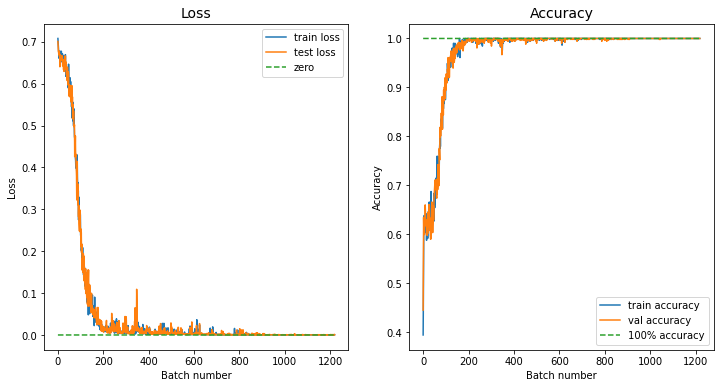

In [29]:
# Инициализируем класс модели, размер внутреннего слоя 16
model = PuzzleLSTM(
    vocab_size=len(letter_index_map),
    hidden_size=16,
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.BCELoss()

n_epochs = 10


losses = []
accs = []

val_losses = []
val_accs = []


for i in range(n_epochs):
    for x_train, y_train in train_sequence_dataloader:

        model.train()
        preds = model(x_train)
        train_loss = loss_func(preds, y_train)
        train_acc = ((preds > 0.5).long() == y_train).float().mean()
        
        optimizer.zero_grad()
        # <your beautiful code here>

        x_val, y_val = next(iter(val_sequence_dataloader))
        
        val_preds = model(x_val)
        val_loss = loss_func(val_preds, y_val)
        val_acc = ((val_preds > 0.5).long() == y_val).float().mean()
        
        losses.append(train_loss.item())
        accs.append(train_acc.item())
        
        val_losses.append(val_loss.item())
        val_accs.append(val_acc.item())
        
        plot_progress(losses, accs, val_losses, val_accs)
